## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                           
model.add(Dense(n_forecast))                                       

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - val_loss: 8.8875e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7590e-04 - val_loss: 6.7057e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9186e-04 - val_loss: 5.9461e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8407e-04 - val_loss: 6.1701e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7695e-04 - val_loss: 5.4502e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2840e-04 - val_loss: 8.1201e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1621e-04 - val_loss: 0.0010
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2275e-04 - val_loss: 9.0635e-04
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1718e-04 - val_loss: 7.7665e-04
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0029e-04 - val_loss: 5.6804e-04
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7901e-04 - val_loss: 5.4052

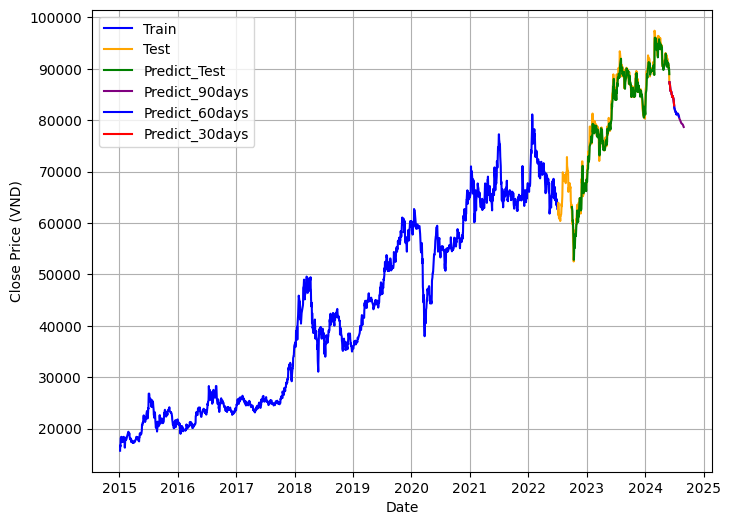

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  87366.242188
2024-06-02  87088.132812
2024-06-03  86958.382812
2024-06-04  86897.859375
2024-06-05  86432.125000
...                  ...
2024-08-25  79001.429688
2024-08-26  78903.781250
2024-08-27  78822.617188
2024-08-28  78753.898438
2024-08-29  78666.265625

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1344.6398317618207
MAPE: 1.2778312825522682 %
MAE: 1010.8473594515931


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                      

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0665 - val_loss: 0.0014
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5046e-04 - val_loss: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8949e-04 - val_loss: 9.8916e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3285e-04 - val_loss: 8.8277e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9587e-04 - val_loss: 9.5650e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7463e-04 - val_loss: 0.0010
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5661e-04 - val_loss: 0.0010
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4069e-04 - val_loss: 0.0013
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4269e-04 - val_loss: 0.0013
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3536e-04 - val_loss: 0.0015
Epoch 12/200
57/57 ━━━━━━━━

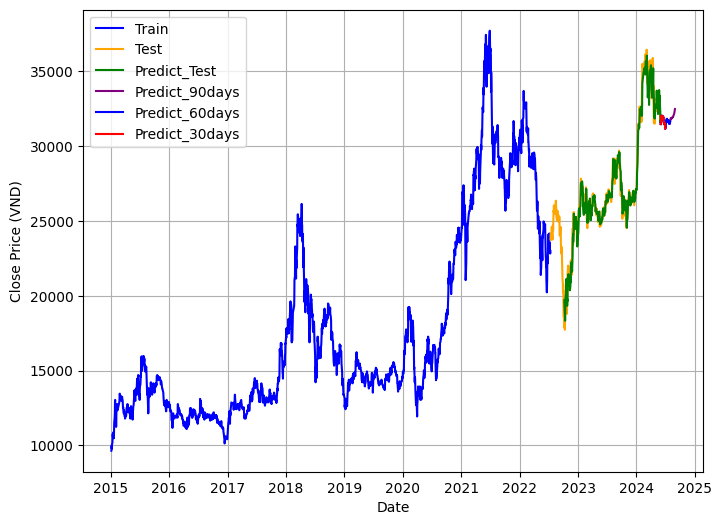

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  31478.548828
2024-06-02  31657.779297
2024-06-03  31622.529297
2024-06-04  31915.972656
2024-06-05  32030.529297
...                  ...
2024-08-25  32227.486328
2024-08-26  32296.693359
2024-08-27  32351.529297
2024-08-28  32439.242188
2024-08-29  32483.027344

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 591.7911501356871
MAPE: 1.6203155277080192 %
MAE: 437.88865754889974


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))        
                               
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 6.5095e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2181e-04 - val_loss: 5.7871e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7912e-04 - val_loss: 5.6635e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6439e-04 - val_loss: 5.9095e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5750e-04 - val_loss: 5.3690e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3413e-04 - val_loss: 5.5914e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2775e-04 - val_loss: 4.5289e-04
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1615e-04 - val_loss: 5.3844e-04
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0905e-04 - val_loss: 4.4639e-04
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0056e-04 - val_loss: 4.3114e-04
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9391e-04 - val_loss: 4.

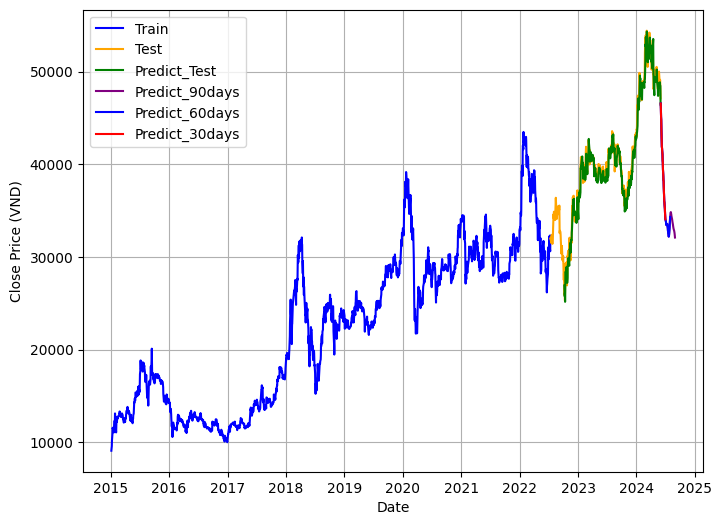

In [10]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  46543.300781
2024-06-02  46020.796875
2024-06-03  45123.796875
2024-06-04  44778.414062
2024-06-05  43844.285156
...                  ...
2024-08-25  32716.414062
2024-08-26  32615.955078
2024-08-27  32471.343750
2024-08-28  32295.996094
2024-08-29  32094.806641

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 907.8404478765906
MAPE: 1.6768750739233766 %
MAE: 670.578979790648
